In [ ]:
##### The typical packages to import.

In [1]:
import astropy.constants as C
import astropy.units as U
import numpy as N

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import datetime

/Users/arthur/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##### The planet class contains all the methods used for the geometry of the planet-star system.

In [2]:
from planet_class import Planet

##### Import the modules for the thermal model (currently a blackbody model).

In [3]:
from thermal import blackbody as thermal_model

##### Import the system properties and data of the desired planet (contained in a Python dictionary in a separate file).

In [4]:
#from data.planet.HD209458b import HD209458b as exoplanet
from data.planet.HATP2b import HATP2b as exoplanet

##### Import the instrumental response data (currently for the Spitzer IRAC bands) and the routine to convert surface temperatures to observed planet-star flux ratios in a given band.

In [5]:
from data.bandpass.spitzer_IRAC import spitzer_IRAC as instrument
from data.bandpass.response import light_curve

/Users/arthur/anaconda/lib/python2.7/site-packages/astropy/analytic_functions/blackbody.py:30: RuntimeWarning: overflow encountered in expm1
  _has_buggy_expm1 = np.isnan(np.expm1(1000))


##### Import the likelihood calculation routine.

In [6]:
from stats.gaussian import log_likelihood
from stats.metropolis import MCMC

##### Import any visualization routines needed.

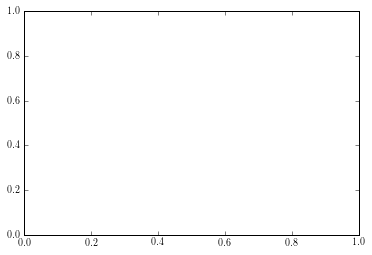

In [7]:
from visualization import multi_animation
from visualization.lightcurve_plot import LightCurvePlot
from visualization.orbit_plot import OrbitPlot
from visualization.surface_plot import SurfacePlot

##### Create a planet instance with the user-supplied system properties.

In [8]:
planet = Planet(exoplanet.system_properties)

##### Specify the spatial and time resolution for the calculations, including the number of orbits to run.

In [9]:
planet.set_resolution(longitude_resolution = 18,
                      latitude_resolution = 8,
                      time_resolution = 100,
                      num_orbits = 2)

##### Specify ranges to be used for the grid in parameter space to be sampled. Make sure that the rotation period is the first parameter. For the blackbody model one also specifies the radiative timescale at 1000 K, the "nightside" (baseline) temperature of the planet, and the global Bond albedo.

In [95]:
prot = N.linspace(1.0, 2.5, num=1) * planet.pseudosynchronous_period()
t1000 = N.linspace(0, 150, num=151)
t1000[0] += 0.001
Tn = N.linspace(1000, 1200, num=1) * U.K
albedo = N.linspace(0.0, 1.0, num=101)

parameters = [prot, t1000*U.hr, Tn, albedo]

##### A wrapper function using the thermal model and light curve routines to start with a set of specified parameter values and return a light curve. This function will be passed to the statistical likelihood function.

In [11]:
def generate_model(parameters, spectral_array):
    temperature_map = thermal_model.temperatures(planet_object=planet, parameters=parameters)
    model = light_curve(planet, temperature_map, spectral_array, prot=parameters[0])
    return {'temp': temperature_map, 'model': model}

##### Call the statistical likelihood function and save the output as an array in parameter space. 'parallel' runs every parameter in parallel using broadcasting in Numpy. If the array is too large, a memory error might result, so use 'serial' instead. Parallel is faster for small array dimensions.

In [ ]:
def mcmc_prior(parameters):
    p, r, T, a = parameters
    lnp = N.where(p>0, 0, -N.inf)
    lnp = N.where(r>0, lnp, -N.inf)
    lnp = N.where(T>0, lnp, -N.inf)
    lnp = N.where(0<=a, lnp, -N.inf)
    lnp = N.where(a<=1, lnp, -N.inf)
    return lnp

In [ ]:
starting_position = {'values': [1, 5, 600, 0.1],
                     'units': [planet.pseudosynchronous_period(), U.hr, U.K, 1]}

In [ ]:
mcmc_model = {}
samples = {}
for band in exoplanet.data:
    print "Band: {0}".format(band)
    mcmc_model[band] = MCMC(planet_object = planet,
                            data = exoplanet.data[band],
                            spectral_array = instrument.bandpass[band],
                            model_function = generate_model)
    mcmc_model[band].set_prior(mcmc_prior)
    mcmc_model[band].set_initial_position(starting_position)
    samples[band] = mcmc_model[band].run_samples(num_walkers=2, num_steps=3, step_size=0.05)

In [ ]:
with open('{0}_mc_pos.npz'.format(datetime.date.today()), 'w') as mc_file:
    N.savez(mc_file, samples['3p6']['pos'], samples['4p5']['pos'], samples['8p0']['pos'])
    
with open('{0}_mc_logl.npz'.format(datetime.date.today()), 'w') as mc_file:
    N.savez(mc_file, samples['3p6']['logl'], samples['4p5']['logl'], samples['8p0']['logl'])

In [105]:
logl_file = N.load('2016-10-12_mc_logl.npz')
mc_logl = {'3p6': logl_file['arr_0'], '4p5': logl_file['arr_1'], '8p0': logl_file['arr_2']}

In [106]:
pos_file = N.load('2016-10-12_mc_pos.npz')
mc_pos = {'3p6': pos_file['arr_0'], '4p5': pos_file['arr_1'], '8p0': pos_file['arr_2']}

In [ ]:
#plt.figure()
#plt.plot(range(samples['4p5']), samples['4p5'])

#i_dict = {0: '3p6', 1: '4p5', 2: '8p0'}

burn_in = 250

fig, axarr = plt.subplots(4)
for i in range(4):
    axarr[i].plot((mc_pos['8p0'].T)[i][0],color='red',alpha=0.3)
    axarr[i].plot((mc_pos['8p0'].T)[i][1],color='green',alpha=0.3)
    axarr[i].plot((mc_pos['8p0'].T)[i][2],color='blue',alpha=0.3)
    axarr[i].plot((mc_pos['8p0'].T)[i][3],color='orange',alpha=0.3)
    #plt.axhline(true_dict[i],color='violet',linewidth=3)
    axarr[i].axvline(burn_in,color='red',linestyle='dashed')
#plt.title(param_name)
#axarr[2].set_ylim((0,1000))
plt.savefig('{0}_{1}_mc_8p0.eps'.format(datetime.date.today(), planet.name))

In [ ]:
burn_in = 250

fig, ax = plt.subplots()
ax.plot((mc_logl['3p6'].T)[0],color='red',alpha=0.3)
ax.plot((mc_logl['3p6'].T)[1],color='green',alpha=0.3)
ax.plot((mc_logl['3p6'].T)[2],color='blue',alpha=0.3)
ax.plot((mc_logl['3p6'].T)[3],color='orange',alpha=0.3)
ax.axvline(burn_in,color='red',linestyle='dashed')
ax.set_xlim((800,850))
ax.set_ylim((0,20))
plt.savefig('{0}_{1}_logl_3p6.eps'.format(datetime.date.today(), planet.name))

In [70]:
logls___ = {}
for band in exoplanet.data:
    print "Band: {0}".format(band)
    logls___[band] = log_likelihood(planet_object = planet,
                                 data = exoplanet.data[band],
                                 spectral_array = instrument.bandpass[band],
                                 model_function = generate_model,
                                 parameters = parameters,
                                 opt = 'parallel')

Band: 4p5
Most favorable parameter values: [<Quantity 1.9462562498294438 d>, <Quantity 50.0 h>, <Quantity 1000.0 K>, 0.51000000000000001]
Band: 8p0
Most favorable parameter values: [<Quantity 1.9462562498294438 d>, <Quantity 27.0 h>, <Quantity 1000.0 K>, 0.51000000000000001]
Band: 3p6
Most favorable parameter values: [<Quantity 1.9462562498294438 d>, <Quantity 39.0 h>, <Quantity 1000.0 K>, 0.51000000000000001]


In [103]:
with open('{0}_{1}_grid.npy'.format(datetime.date.today(), planet.name), 'w') as grid_file:
    N.save(grid_file, logls_comp)

##### Pull the most favorable parameter values and make a grid of that single set to plot the flux curve(s). Then generate models for the most favorable parameters in each band.

In [72]:
best_parameters = {}
best_rotation = {}
best_paramgrid = {}
best_model = {}

for band in exoplanet.data:
    best_parameters[band] = [par[j].reshape(1)[0] for par, j in zip(parameters, logls[band]['index'])]
    best_rotation[band] = best_parameters[band][0]
    best_paramgrid[band] = N.meshgrid(*best_parameters[band])
    
    #For purposes of plotting and displays, let's bump up the resolution.
    #We only need to generate a single model for each band.
    planet.set_resolution(longitude_resolution = 360,
                          latitude_resolution = 180,
                          time_resolution = 100,
                          num_orbits = 2)
    
    best_model[band] = generate_model(best_paramgrid[band], instrument.bandpass[band])
    best_model[band]['model'] = best_model[band]['model'].reshape(planet.time_resolution*planet.num_orbits)
    best_model[band]['temp'] = best_model[band]['temp'].reshape(planet.time_resolution*planet.num_orbits, planet.latitude_resolution+1, planet.longitude_resolution+1)

##### This routine compiles the flux curves for all calculated periastron-to-periastron orbits, to show how rotation periods other than synchronous with orbital period can cause the flux curve to change each orbit.

In [ ]:
orbital_fluxes = best_model['4p5']['model'][planet.time_resolution/2:-planet.time_resolution/2].reshape((planet.num_orbits-1,planet.time_resolution))
y, x = N.meshgrid(range(planet.time_resolution),range(planet.num_orbits-1))
plt.pcolor(x,y,orbital_fluxes,cmap="RdBu", vmin=1.000, vmax=1.002)
plt.colorbar()
plt.savefig("{0}_{1}_orbitevo.pdf".format(datetime.date.today(), planet.name))

In [93]:
logls_comp = {}
for band in logls:
    logls_comp[band] = N.c_[N.r_[logls[band]['logl'], logls_[band]['logl'], logls__[band]['logl']], N.r_[logls___[band]['logl'], logls____[band]['logl'], logls_____[band]['logl']]]
    logls_comp[band] = logls_comp[band].reshape(151,101)

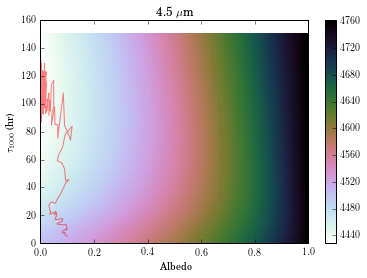

In [109]:
x, y = N.meshgrid(albedo, t1000)
plt.pcolor(x, y, logls_comp['4p5'], cmap='cubehelix_r')
plt.colorbar()
plt.plot(mc_pos['4p5'].T[1][0], mc_pos['4p5'].T[0][0], color='red', alpha=0.5)
#plt.plot(mc_pos['8p0'].T[1][1], mc_pos['8p0'].T[0][1], color='green', alpha=0.3)
#plt.plot(mc_pos['8p0'].T[1][2], mc_pos['8p0'].T[0][2], color='blue', alpha=0.3)
#plt.plot(mc_pos['8p0'].T[1][3], mc_pos['8p0'].T[0][3], color='orange', alpha=0.3)
plt.xlabel(r'Albedo')
plt.ylabel(r'$\tau_{1000}$ (hr)')
plt.title(r'4.5 $\mu$m')
plt.savefig('{0}_{1}_loglgrid_4p5.pdf'.format(datetime.date.today(), planet.name))

##### Create some plot objects. The orbit plot shows the outline and motion/phases over the orbit, showing the rotation. The surface plot shows the evolution of surface temperatures, but can be used to show any planet surface quantity over time.

In [73]:
lightcurve_plot = LightCurvePlot(planet, exoplanet.data, best_model, best_parameters)
orbit_plot = OrbitPlot(planet,
                       rotation_period = best_rotation['3p6'])
surface_plot = SurfacePlot(planet,
                           rotation_period = best_rotation['3p6'],
                  
                           map_array = best_model['3p6']['temp'].reshape(planet.time_resolution*planet.num_orbits, planet.latitude_resolution+1, planet.longitude_resolution+1))

##### Plot the data vs. models. The models shown correspond to the best-fit parameters for each band, which may or may not agree with each other.

In [114]:
q = N.zeros((4,1))
print q.any() == 1

False


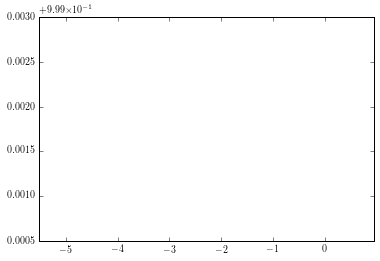

In [74]:
fig, ax = plt.subplots()
lightcurve_plot.draw(axis=ax, save=True)

##### This animation routine accepts a list of plot objects to animate. Here I chose the orbit and surface maps.

In [ ]:
animation = multi_animation.draw(planet, [orbit_plot, surface_plot])



##### Plot a grid of likelihood contour maps, showing the regions of most favorable parameter values for each wavelength band.

In [ ]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

num_columns = N.sum(wavelengths_use)
column_order = [N.sum(wavelengths_use[:n]) for n in xrange(len(wavelengths_use))]
num_rows = N.shape(planet.beta)[2]

likelihood_figure, axes = plt.subplots(num_rows, num_columns, sharex=True)

level_min = N.ceil(N.min([logl[key]['logl'] for key in logl.keys()]))
level_max = N.ceil(N.max([logl[key]['logl'] for key in logl.keys()]))
level_step = 10**(N.floor(N.log10(level_max))-1)
levels = N.arange(start=level_min, stop=level_max, step=2*level_step)

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        cell.yaxis.tick_right()
        if use_3p6 and j == column_order[0]:
            cell.set_axis_bgcolor('#D9B2F0')
            im = cell.contour(rot_psr, t_rad, logl['3p6']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            if i == 0: cell.set_title(r'$3.6 \mu$m', fontsize=15, color='#6E209C')
        if use_4p5 and j == column_order[1]:
            im = cell.contour(rot_psr, t_rad, logl['4p5']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            cell.set_axis_bgcolor('#FFD4BA')
            if i == 0: cell.set_title(r'$4.5 \mu$m', fontsize=15, color='#E97025')
        if use_5p8 and j == column_order[2]:
            im = cell.contour(rot_psr, t_rad, logl['5p8']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            cell.set_axis_bgcolor('#C5F8B5')
            if i == 0: cell.set_title(r'$5.8 \mu$m', fontsize=15, color='#47C61F')
        if use_8p0 and j == column_order[3]:
            im = cell.contour(rot_psr, t_rad, logl['8p0']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            cell.set_axis_bgcolor('#F8B5D2')
            if i == 0: cell.set_title(r'$8.0 \mu$m', fontsize=15, color='#C51F68')
        
        if j == 0: cell.set_ylabel('%i' % nighttemp[num_rows-(i+1)].value, fontsize=12)
        if j != num_columns-1:
            cell.yaxis.set_ticklabels([])
            
        #im = cell.imshow(likelihoods[j,:,:,i], interpolation='bilinear', origin='lower', cmap=cm.viridis)
        cell.clabel(im, inline=1, fmt='%i', fontsize=8)
        
likelihood_figure.text(0.5, 0.01, r'$P_{\mathrm{rot}}/P_{\mathrm{PSR}}$', fontsize=15, ha='center')
likelihood_figure.text(0.97, 0.5, r'$t_{\mathrm{rad}}$ (hr) at 1000 K', fontsize=15, va='center', rotation='vertical')
likelihood_figure.text(0.03, 0.5, r'$T_{\mathrm{n}}$ (K)', fontsize=15, va='center', rotation='vertical')
likelihood_figure.tight_layout
plt.savefig('{0}_likelihood_{1}.eps'.format(datetime.date.today(), planet.name))

In [ ]:
print best_grid(logl['4p5'])
print data_4p5

In [ ]:
def bootstrap(data, response, passband, num_samples):
    variance = 0
    best_values = best_grid(logl[passband])
    betas, rots, nighttemps = best_values['mesh']
    planet.set_custom_parameters(beta=betas,
                               rotation_period=rots,
                               nightside_temperature=nighttemps)
    planet.set_albedo(best_values['albedo'])
    data_resample = data.copy()
    for i in xrange(num_samples):
        resample = N.random.choice(range(N.shape(data)[0]), size=N.shape(data)[0], replace=True)
        for j in xrange(N.shape(data)[0]):
            data_resample.values[j] = N.array([data.t[resample[j]], data.flux[resample[j]]])
        logl_resample = planet.log_likelihood(data_resample, response, time_cut)
        var_i = (logl_resample['logl'] - best_values['logl'])**2 / num_samples
        variance += var_i
    
    return N.sqrt(variance)

In [ ]:
print bootstrap(data_4p5, spitzer_4p5, '4p5', 100)

In [ ]:
print best_grid(logl['4p5'])['logl']